# Reparametrization of Curves 

In [151]:
# Remove from public version
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


from funcshape.networks import CurveReparametrizer
from funcshape.layers.sineseries import SineSeries
from funcshape.logging import Logger
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [153]:
def gaussian(t, p):
    out = np.zeros(t.shape)
    for i in range(1,p+1):
        zi = np.random.normal(1, 0.1)
        mean = (2*i-1)/(2*p)
        sigma = 1/(3*p)
        factor = 1/(2*(sigma**2))
        phi =  np.exp(-factor*(t-mean)**2)
        out += zi*phi

    return out

def warping(t):
    a = np.random.uniform(-3, 3)
    if a==0:
        gam = t
    else:
        gam = (np.exp(a*t)-1)/(np.exp(a)-1)

    return gam

class Function:
    def __init__(self, x, fx):
        self.x = x
        self.fx = fx
        coeffs = natural_cubic_spline_coeffs(self.x, self.fx)
        self.spline = NaturalCubicSpline(coeffs)

    def __call__(self, x):
        return self.spline.evaluate(x)

    def derivative(self, x, h=None):
        return self.spline.derivative(x, order=1)
    
    def compose(self, f):
        fx = f(self.x)
        y = self.spline.evaluate(fx).squeeze(-1)
        
        return Function(self.x, y)

### Display Figures Before Reparametrization

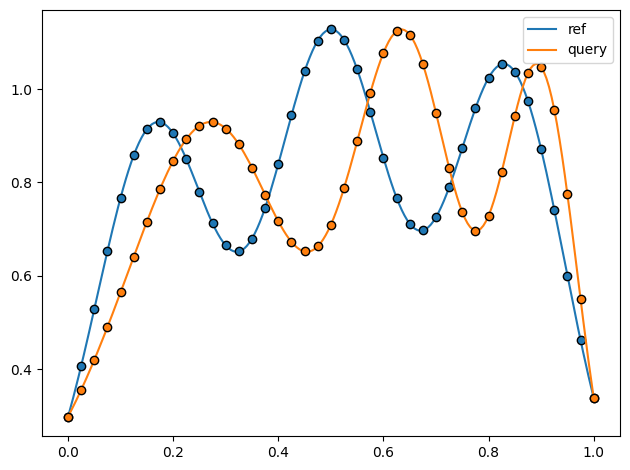

In [173]:
# Get function and a random warping function
time = torch.linspace(0,1,100)
t_ = np.linspace(0,1, len(time))
gamma = warping(t_)
f1_ = gaussian(t_, 3) #np.random.randint(1,3))

# Define function objects 
f1 = Function(time, torch.from_numpy(f1_).reshape(-1,1))
diff = Function(time, torch.from_numpy(gamma).reshape(-1,1))
f2 = f1.compose(diff)
f2_ = f2(time).squeeze().numpy()

def plot_function(f, npoints=201, dotpoints=None, ax=None, **kwargs):
    x = torch.linspace(0, 1, npoints).squeeze()
    fx = f(x).squeeze()

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, fx, **kwargs)

    if dotpoints is not None:
        x = torch.linspace(0, 1, dotpoints).squeeze()
        fx = f(x).squeeze()
        ax.plot(
            x,
            fx,
            c=ax.lines[-1].get_color(),
            ls="none",
            marker="o",
            markeredgecolor="black",
        )

    return ax

fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
ax.legend()
plt.tight_layout()
plt.show()

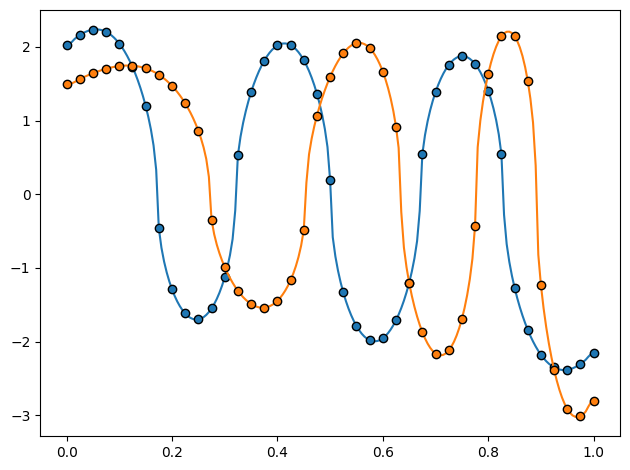

In [174]:
# Get SRSF maps
class SRSF:
    """SRSF transformation of functions"""

    def __init__(self, f : Function)-> None:
        self.f = f

    def __call__(self, x, h=None):
        grad = self.f.derivative(x)
        q = grad / torch.sqrt(torch.abs(grad) + 1e-3)
        
        return q
    
q1, q2 = SRSF(f1), SRSF(f2)
fig, ax =plt.subplots()
plot_function(q1, dotpoints=41, ax=ax)
plot_function(q2, dotpoints=41, ax=ax)
plt.tight_layout()
plt.show()

In [175]:
from funcshape.loss import ShapeDistanceBase 

class FunctionDistance(ShapeDistanceBase):
    def create_point_collection(self, k):
        return col_linspace(0, 1, k)

    def get_determinant(self, network):
        return network.derivative(self.X, self.h)

    def loss_func(self, U, Y):
        error = ((self.Q.squeeze(-1) - torch.sqrt(U + 1e-8) * self.r(Y, self.h).squeeze(-1)) ** 2)
        l2_norm = torch.trapezoid(error.squeeze(), x=self.X.squeeze())
        
        return l2_norm

In [176]:
N_BASIS = 20 
N_LAYERS = 50
LR = 3e-4
N_ITERS = 1000
NUM_DOMAIN_POINTS = 100
N_RESTRATS = 10

# Define loss, optimizer and run reparametrization.
loss_func = FunctionDistance(q1, q2, k=NUM_DOMAIN_POINTS)

best_error = np.inf
for _ in range(N_RESTRATS):
    # Create reparametrization network
    RN = CurveReparametrizer([
        SineSeries(N_BASIS) for i in range(N_LAYERS)
    ])

    optimizer = optim.Adam(RN.parameters(), lr=LR)
    # optimizer = optim.LBFGS(RN.parameters(), lr=LR, max_iter=N_ITERS, line_search_fn="strong_wolfe")
    error = reparametrize(RN, loss_func, optimizer, N_ITERS, Logger(100))

    if error[-1]<best_error:
        best_error = error[-1]
        best_RN = RN
        print("Current best error : %2.4f"%best_error)


# Get plot data to visualize diffeomorphism
best_RN.detach()
x = col_linspace(0, 1, NUM_DOMAIN_POINTS)
y = best_RN(x)

[Iter     1] loss: 5.206552
[Iter   101] loss: 1.518796
[Iter   201] loss: 0.871447
[Iter   301] loss: 0.703787
[Iter   401] loss: 0.645151
[Iter   501] loss: 0.619851
[Iter   601] loss: 0.607010
[Iter   701] loss: 0.599050
[Iter   801] loss: 0.594164
[Iter   901] loss: 0.590841

Finished training in 23.06981s
Current best error : 0.5887
[Iter     1] loss: 6.526317
[Iter   101] loss: 2.752737
[Iter   201] loss: 1.706973
[Iter   301] loss: 1.393640
[Iter   401] loss: 1.211539
[Iter   501] loss: 1.070445
[Iter   601] loss: 0.965962
[Iter   701] loss: 0.907771
[Iter   801] loss: 0.866049
[Iter   901] loss: 0.837186

Finished training in 25.78091s
[Iter     1] loss: 4.373683
[Iter   101] loss: 1.299388
[Iter   201] loss: 0.887231
[Iter   301] loss: 0.629728
[Iter   401] loss: 0.523967
[Iter   501] loss: 0.443927
[Iter   601] loss: 0.422751
[Iter   701] loss: 0.410324
[Iter   801] loss: 0.400072
[Iter   901] loss: 0.393088

Finished training in 23.27031s
Current best error : 0.3880
[Iter   

In [177]:
from apdist import SquareRootSlopeFramework as SRSF_

srsf = SRSF_(t_)
q_ref = srsf.to_srsf(f1_)
q_query = srsf.to_srsf(f2_)
optim_kwargs = {"optim":"DP", "grid_dim":60}
gamma_dp = srsf.get_gamma(q_ref, q_query, **optim_kwargs)


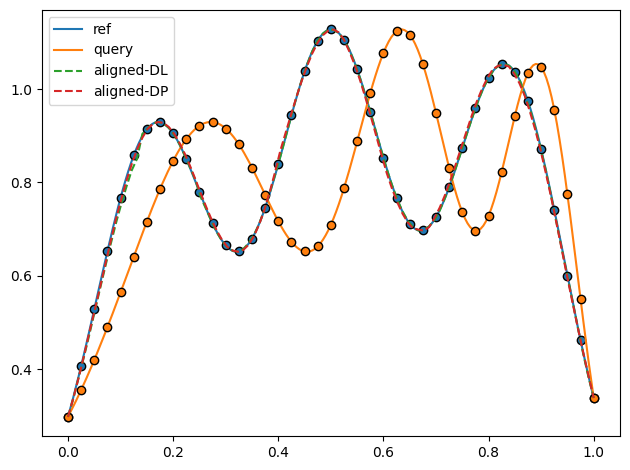

In [178]:
# Plot reparametrized curves and original
fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
f_query_gamma = srsf.warp_f_gamma(f2_, gamma_dp)
ax.plot(x, f2(y).squeeze(), ls='--', label="aligned-DL")
ax.plot(t_, f_query_gamma.squeeze(), ls='--', label="aligned-DP")
ax.legend()
plt.tight_layout()
plt.show()

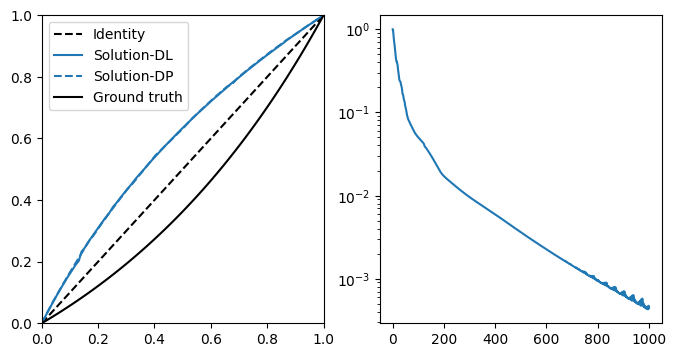

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(t_, t_, label="Identity", color="k", ls='--')
ax1.plot(x, y, label="Solution-DL")
ax1.plot(t_, gamma_dp, label="Solution-DP",
         ls = '--', color=ax1.lines[-1].get_color())
ax1.plot(t_, gamma, label="Ground truth", color="k")
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(error / error[0])
plt.show()